In [1]:
from src.preprocessing import *
from src.metrics import *
from src.visualisation import *
from src.NetworkGraphs import *

In [2]:
networkGraphs = NetworkGraphs('../datasets/Railway.csv', type="RAILWAY", spatial =True)

Excluded 6022 stations


In [3]:
networkGraphs.__dict__

{'filename': '../datasets/Railway.csv',
 'name': 'Railway',
 'type': 'RAILWAY',
 'temporal': False,
 'spatial': True,
 'DiGraph': <networkx.classes.digraph.DiGraph at 0x14184d400>,
 'MultiDiGraph': <networkx.classes.multidigraph.MultiDiGraph at 0x1418efb20>,
 'Graph': <networkx.classes.graph.Graph at 0x105954580>,
 'MultiGraph': <networkx.classes.multigraph.MultiGraph at 0x105954700>,
 'pos': {692: (112.58682, 37.86048),
  1351: (112.73118, 37.69719),
  698: (112.57032, 37.42136),
  944: (112.16847, 37.20661),
  232: (111.91906, 37.01847),
  1639: (111.77102, 36.86171),
  2335: (111.71973, 36.58583),
  1512: (111.67162, 36.26214),
  127: (111.53682, 36.08683),
  259: (111.3585, 35.61313),
  1835: (110.99518, 35.6127),
  1480: (110.72605, 35.58776),
  2362: (110.44188, 35.48393),
  503: (110.09119, 35.19518),
  1009: (109.40295, 34.77167),
  2058: (108.96283, 34.27727),
  802: (107.15321, 34.37297),
  681: (105.8986, 34.56586),
  1704: (105.33231, 34.76293),
  2314: (104.70544, 34.95238

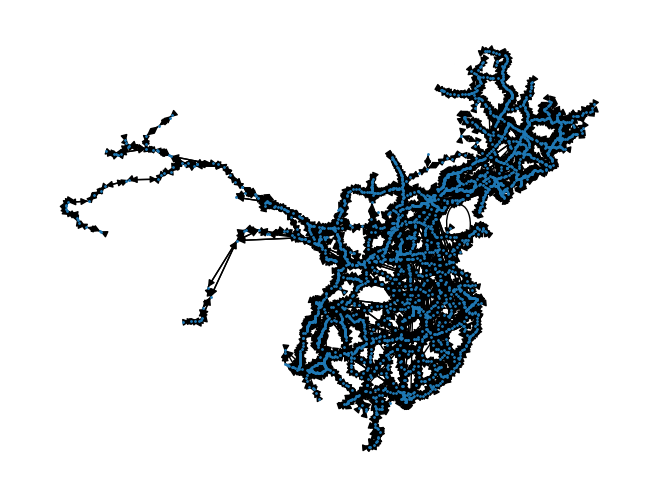

In [4]:
nx.draw(networkGraphs.DiGraph, networkGraphs.pos, node_size=1)

In [2]:
networkx, multi_networkx = preprocess('../datasets/Railway.csv', DatasetType.RAILWAY)

Excluded 6022 stations


In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ipywidgets as widgets
from IPython.display import display
%matplotlib notebook

# Graph Statistics

In [7]:
global_metrics = compute_global_metrics(networkx)
global_metrics

,Metrics,Directed,Undirected
0,Clustering Coefficient,0.377180,0.422829
1,Avg. Shortest Path Length,0.000000,8.786388
2,Diameter,0.000000,47.000000
3,Radius,0.000000,24.000000
4,Number of Nodes,2719.000000,2719.000000
5,Number of Edges,10778.000000,6175.000000
6,Density,0.001458,0.001671
7,Transitivity,0.292370,0.321659
8,Avg. Degree,7.927915,4.542111
9,Avg. Clustering,0.377180,0.422829


,Metrics,Directed,Undirected
0,Clustering Coefficient,0.377180,0.422829
1,Avg. Shortest Path Length,0.000000,8.786388
2,Diameter,0.000000,47.000000
3,Radius,0.000000,24.000000
4,Number of Nodes,2719.000000,2719.000000
5,Number of Edges,10778.000000,6175.000000
6,Density,0.001458,0.001671
7,Transitivity,0.292370,0.321659
8,Avg. Degree,7.927915,4.542111
9,Avg. Clustering,0.377180,0.422829


In [8]:
directed_node_metrics = compute_node_metrics(networkx)
directed_node_metrics

,Degree Centrality,Closeness Centrality,Betweeness Centrality,Eigenvector Centrality
692,0.008094,0.146138,0.025283,1.613618e-02
1351,0.005519,0.136173,0.015457,4.355226e-03
698,0.002208,0.119821,0.000544,6.230837e-04
944,0.003679,0.127892,0.000967,2.012309e-03
232,0.005151,0.120029,0.007658,6.061874e-04
...,...,...,...,...
2768,0.001472,0.086094,0.002926,1.448486e-07
2679,0.001472,0.079258,0.002195,1.301788e-08
2657,0.001472,0.073423,0.001464,1.169981e-09
2682,0.001472,0.068386,0.000732,1.051485e-10


,Degree Centrality,Closeness Centrality,Betweeness Centrality,Eigenvector Centrality
692,0.008094,0.146138,0.025283,1.613618e-02
1351,0.005519,0.136173,0.015457,4.355226e-03
698,0.002208,0.119821,0.000544,6.230837e-04
944,0.003679,0.127892,0.000967,2.012309e-03
232,0.005151,0.120029,0.007658,6.061874e-04
...,...,...,...,...
2768,0.001472,0.086094,0.002926,1.448486e-07
2679,0.001472,0.079258,0.002195,1.301788e-08
2657,0.001472,0.073423,0.001464,1.169981e-09
2682,0.001472,0.068386,0.000732,1.051485e-10


In [9]:
undirected_node_metrics = compute_node_metrics(networkx.to_undirected())
undirected_node_metrics

,Degree Centrality,Closeness Centrality,Betweeness Centrality,Eigenvector Centrality
692,0.004415,0.155181,0.022524,8.662295e-03
1351,0.003679,0.143794,0.016451,2.183319e-03
698,0.001104,0.125740,0.000000,2.516111e-04
944,0.002208,0.134828,0.001943,8.853901e-04
232,0.002943,0.125985,0.007017,2.492824e-04
...,...,...,...,...
2768,0.000736,0.090018,0.002940,3.234174e-08
2679,0.000736,0.082601,0.002206,2.466000e-09
2657,0.000736,0.076310,0.001471,1.880379e-10
2682,0.000736,0.070905,0.000736,1.433865e-11


,Degree Centrality,Closeness Centrality,Betweeness Centrality,Eigenvector Centrality
692,0.004415,0.155181,0.022524,8.662295e-03
1351,0.003679,0.143794,0.016451,2.183319e-03
698,0.001104,0.125740,0.000000,2.516111e-04
944,0.002208,0.134828,0.001943,8.853901e-04
232,0.002943,0.125985,0.007017,2.492824e-04
...,...,...,...,...
2768,0.000736,0.090018,0.002940,3.234174e-08
2679,0.000736,0.082601,0.002206,2.466000e-09
2657,0.000736,0.076310,0.001471,1.880379e-10
2682,0.000736,0.070905,0.000736,1.433865e-11


# VISUALISATION

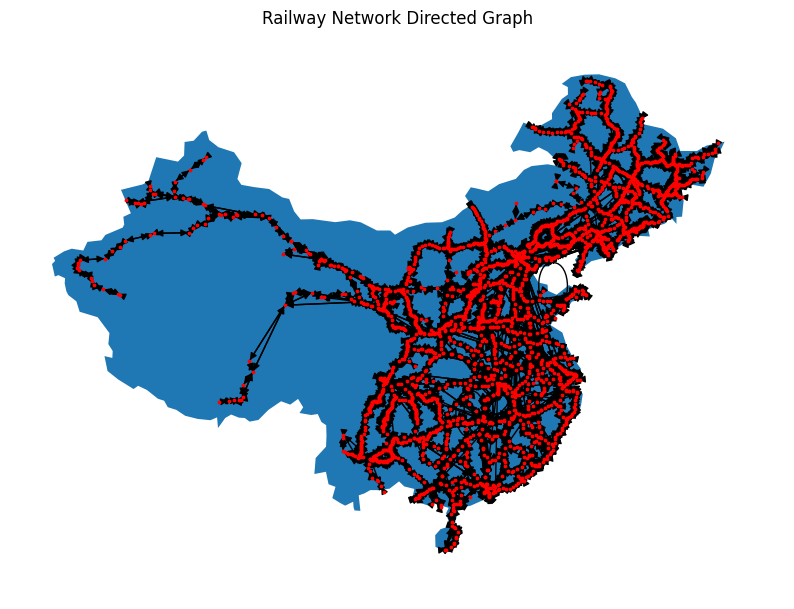

In [5]:
plt_directed = plot_static_on_map(networkx, 'Railway Network Directed Graph', directed=True)

In [ ]:
plt_undirected = plot_static_on_map(networkx, 'Railway Network Undirected Graph', directed=False)

# Spatial and Temporal Analysis

### Create frames of the graph
May take very long to create all of the frame images for 2 Days, one frame is created every 5 minute. You may change the range to create less frames and a shorter video.

In [6]:
temporal_graphs = create_temporal_subgraph(multi_networkx)

NameError: name 'temporal_graphs' is not defined

In [10]:
slider, plt = plot_temporal_graphs(temporal_graphs)
display(slider)
plt.show()

### Create a video of the graph with cv2 (OpenCV)

In [9]:
# import cv2
# import os
#
# # Path to the folder containing the image frames
# frames_folder = 'frames/'
#
# # Get the list of frame filenames in the folder
# frame_filenames = os.listdir(frames_folder)
#
# # Sort the filenames in ascending order
# frame_filenames.sort(key=lambda x: int(x[:-4]))
#
# # Read the first frame to get its dimensions
# frame = cv2.imread(frames_folder + frame_filenames[0])
# height, width, layers = frame.shape
#
# # Create a VideoWriter object to write the video
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# video = cv2.VideoWriter('output.mp4', fourcc, 30, (width, height))
#
# # Loop through the frames and add them to the video
# i=0
# for filename in frame_filenames:
#     frame = cv2.imread(frames_folder + filename)
#     video.write(frame)
#     print(f"\r{i/2764*100:.2f}%", end="")
#     i+=1
#
# # Release the VideoWriter object and display a message
# video.release()
# print('\nVideo saved as output.mp4')

# SHORTEST PATH ANALYSIS

In [4]:
# def shortest_path(G, source, target):
#     return nx.shortest_path(G, source=source, target=target)

[1136, 1763, 389, 390, 2058, 802, 1070, 2065, 1100, 2144, 1095]

In [6]:
networkx

[1136, 1763, 389, 390, 2058, 802, 1070, 2065, 1100, 2144, 1095]

In [7]:
nx.shortest_path(networkx, source=1136, target=1095)

[1136, 1763, 389, 390, 2058, 802, 1070, 2065, 1100, 2144, 1095]

In [9]:
# Network Graph with the shortest path highlighted
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

china=world[world['name'] == 'China']
china.plot(figsize=(10,10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=1, node_color='red')

shortest_path = nx.shortest_path(G, source=1095, target=1136)
nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_size=10, node_color='yellow')
nx.draw_networkx_edges(G, pos, edgelist=list(zip(shortest_path, shortest_path[1:])), edge_color='yellow', width=3)

plt.axis('on')
plt.title("Shortest Path between 1136 and 1095")
plt.show()


<IPython.core.display.Javascript object>

NetworkXNoPath: No path between 1095 and 1136.